In [108]:
from sklearn import svm
import GPyOpt, numpy as np, seaborn as sns, matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%run collect_and_name_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [3]:
from paramz import Model, Param

In [248]:
class ParamzSVC(Model):
    def __init__(self, X, y, C=1., gamma=1., name='ParamzSVC'):
        from sklearn.cross_validation import StratifiedKFold
        super(ParamzSVC, self).__init__(name=name)

        self.X = X
        self.y = y
        
        self.C = Param('C', C)
        self.gamma = Param('gamma', gamma)
        self.link_parameter(self.C)
        self.link_parameter(self.gamma)
        
        self._accuracies = np.empty((10,5))
        self.sk = StratifiedKFold(train_labels, shuffle=True, n_folds=self._accuracies.shape[1])
        
    def parameters_changed(self):
        from sklearn.metrics import f1_score, accuracy_score
    
    
        #svc = svm.LinearSVC(C=float(self.C.values), class_weight='balanced')
        svc = svm.SVC(C=float(self.C.values), 
                      gamma=float(self.gamma.values), 
                      kernel='rbf', 
                      decision_function_shape='ovr', 
                      probability=False, 
                      class_weight='balanced')
    
        for i in range(self._accuracies.shape[0]):
            j = 0
            for train_index, test_index in self.sk:
                svc = svc.fit(self.X[train_index], self.y[train_index])
                prediction = svc.predict(self.X[test_index])
                #self._obj += accuracy_score(self.y[test_index], prediction)
                self._accuracies[i,j] = accuracy_score(self.y[test_index], prediction)
                j += 1
                
        self._obj = self._accuracies.mean()

        
    def objective_function(self):
        import numpy as np
        #print self._obj,
        return -np.atleast_1d(self._obj)

In [249]:
train_idx = design.Set == design.Set.unique()[0]
test_idx = ~train_idx    

train_labels = design.loc[train_idx, 'Effect']
test_labels = design.loc[test_idx, 'Effect']

In [250]:
def get_train_test_set(data, train_idx, test_idx):
    train_set = data.loc[:, train_idx].copy()
    from sklearn.preprocessing import StandardScaler
    normalizer = StandardScaler()
    train_set[:] = normalizer.fit_transform(train_set.T).T

    test_set = data.loc[:, test_idx].copy()
    test_set[:] = normalizer.transform(test_set.T).T
    
    return train_set, test_set

In [251]:
def make_f(m):
    def f(X):
        ret = np.empty((X.shape[0],1))
        for i in range(X.shape[0]):
            ret[i] = m._objective(X[i])
        return ret
    return f

In [252]:
train_errors = {}

for i in range(len(all_data)):
    data = all_data[i]
    print data.name
    train_set, test_set = get_train_test_set(data, train_idx, test_idx)
    
    m = ParamzSVC(train_set.T.values, train_labels.values)
    m_opt = GPyOpt.methods.BayesianOptimization(make_f(m), 
                                            bounds=[
                                                    (np.exp(-5),np.exp(15)),
                                                    (np.exp(-15),np.exp(5))
                                                    ], 
                                            model_optimize_restarts = 20,
                                            normalize=True,
                                            acquisition = 'EI',
                                            type_initial_design='latin')
    print
    m_opt.run_optimization(60, eps=1e-5)
    print
    train_errors[data.name] = [m_opt.fx_opt, m_opt.x_opt]

all_genes

*Optimization completed:
   -Maximum number of iterations reached.

effector_genes

*Optimization completed:
   -Maximum number of iterations reached.

mod_activities

*Optimization completed:
   -Maximum number of iterations reached.

mod_genevalues

*Optimization completed:
   -Maximum number of iterations reached.

mod_nodevalues

*Optimization completed:
   -Maximum number of iterations reached.

signaling_genes

*Optimization completed:
   -Maximum number of iterations reached.



In [253]:
train_errors

{'all_genes': [array([-0.29642857]),
  array([  1.36209058e+06,   8.65743429e+01])],
 'effector_genes': [array([-0.29642857]),
  array([  2.99659926e+06,   8.65743429e+01])],
 'mod_activities': [array([-0.29642857]),
  array([  8.17254348e+05,   1.36045396e+02])],
 'mod_genevalues': [array([-0.29642857]),
  array([  1.36209058e+06,   8.65743429e+01])],
 'mod_nodevalues': [array([-0.29642857]),
  array([  1.90692680e+06,   6.18388165e+01])],
 'signaling_genes': [array([-0.29642857]),
  array([  2.99659926e+06,   1.11309869e+02])]}

In [204]:
results = pd.DataFrame(columns=['acc', 'C', 'gamma'], 
                       index=train_errors.keys(),
                       dtype=float)
acc, cg = zip(*train_errors.values())
results['acc'] = -np.concatenate(acc)
C,g = [[_c[i] for _c in cg] for i in range(2)]
results['C'] = C
results['gamma'] = g

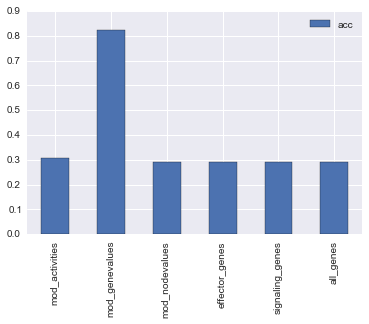

In [205]:
results.plot(kind='bar', y='acc')

In [206]:
best = results.acc.idxmax(0)
print best

mod_genevalues


## Work on best training data:

In [207]:
svc = svm.SVC(C=results.loc[best, 'C'], 
                      gamma=results.loc[best, 'gamma'], 
                      kernel='rbf', 
                      decision_function_shape='ovr', 
                      probability=True, 
                      class_weight='balanced')

In [208]:
train_set, test_set = get_train_test_set(rnaseq_mod_genevalues, train_idx, test_idx)
svc.fit(train_set.T.values, train_labels)

SVC(C=3177106.1518320823, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0068880455480137392,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [209]:
prediction_probabilities = pd.DataFrame(svc.predict_proba(test_set.T.values), index=test_set.columns, columns=svc.classes_)

In [210]:
test_labels.value_counts()
test_labels_collected = test_labels.copy()
test_labels_collected[(test_labels_collected=='Effect_6')+(test_labels_collected=='Effect_7')] = 'Unknown'
#test_labels_collected = pd.get_dummies(test_labels_collected)

## Roc curve for each class:

In [211]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [212]:
rocs = {}
for c in prediction_probabilities.columns:
    rocs[c] = roc_curve(test_labels_collected==c, prediction_probabilities[c])

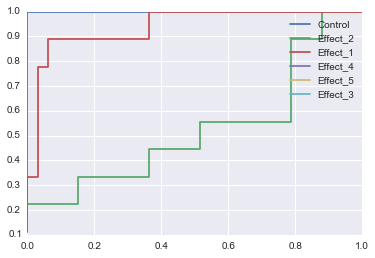

In [213]:
for name in rocs:
    plt.plot(rocs[name][0], rocs[name][1], label=name)
plt.legend()

## Try to use the predicted probabilities to find unknown classes:

In [224]:
def predict_classes(prediction_probabilities, threshold):
    import scipy
    #sort = np.argsort(prediction_probabilities, 1).values[:, ::-1]
    prediction = prediction_probabilities.idxmax(1)
    #score = prediction_probabilities.std(1)
    score = prediction_probabilities.max(1)
    prediction[score<threshold] = 'Unknown'
    return prediction

In [225]:
thresholds = np.linspace(0,1,300)
accs = pd.DataFrame(columns=['acc', 'prec', 'recall'], index=thresholds)
for t in thresholds:
    prediction = predict_classes(prediction_probabilities, t)
    accs.loc[t] = [accuracy_score(test_labels_collected, prediction), precision_score(test_labels_collected, prediction), recall_score(test_labels_collected, prediction)]

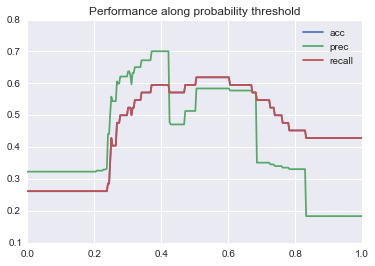

In [226]:
ax = accs.plot()
ax.set_title('Performance along probability threshold')

In [228]:
from sklearn.metrics import confusion_matrix

In [254]:
best = prediction_probabilities.idxmax(1)
score = prediction_probabilities.max(1)
best[score<accs.acc.max()] = 'Unknown'

In [255]:
best

RNAseq22     Control
RNAseq23    Effect_2
RNAseq24     Unknown
RNAseq25     Unknown
RNAseq26     Unknown
RNAseq27     Control
RNAseq28     Unknown
RNAseq29     Unknown
RNAseq30     Unknown
RNAseq31     Unknown
RNAseq32     Unknown
RNAseq34     Unknown
RNAseq35     Unknown
RNAseq36     Unknown
RNAseq38     Control
RNAseq39     Unknown
RNAseq40     Unknown
RNAseq41     Unknown
RNAseq42     Unknown
RNAseq43     Control
RNAseq44     Unknown
RNAseq45     Unknown
RNAseq46     Unknown
RNAseq47     Unknown
RNAseq48     Unknown
RNAseq50     Unknown
RNAseq51     Unknown
RNAseq52     Unknown
RNAseq54     Control
RNAseq55     Unknown
RNAseq56     Unknown
RNAseq57     Unknown
RNAseq58     Unknown
RNAseq59     Control
RNAseq60     Unknown
RNAseq61     Unknown
RNAseq62     Unknown
RNAseq63     Unknown
RNAseq64     Unknown
RNAseq66     Unknown
RNAseq67     Unknown
RNAseq68     Unknown
dtype: object

In [234]:
best.unique(),test_labels_collected.unique()

(array(['Control', 'Effect_2', 'Unknown'], dtype=object),
 array(['Control', 'Effect_2', 'Unknown', 'Effect_1'], dtype=object))

In [235]:
print classification_report(test_labels_collected, best,)

             precision    recall  f1-score   support

    Control       1.00      1.00      1.00         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       1.00      0.22      0.36         9
    Unknown       0.53      1.00      0.69        18

avg / total       0.58      0.62      0.52        42



In [238]:
print "Best accuracy by choosing threshold = {:.0%}".format(accuracy_score(test_labels_collected, best))

Best accuracy by choosing threshold = 62%


In [245]:
_labs = test_labels_collected.unique()

In [246]:
pd.DataFrame(confusion_matrix(test_labels_collected, best, labels=_labs), index=_labs, columns=_labs)

,Control,Effect_2,Unknown,Effect_1
Control,6,0,0,0
Effect_2,0,2,7,0
Unknown,0,0,18,0
Effect_1,0,0,9,0


In [247]:
test_labels_collected

SampleID_RNASeq
RNAseq22     Control
RNAseq23    Effect_2
RNAseq24    Effect_2
RNAseq25    Effect_2
RNAseq26     Unknown
RNAseq27     Control
RNAseq28     Unknown
RNAseq29     Unknown
RNAseq30     Unknown
RNAseq31     Unknown
RNAseq32     Unknown
RNAseq34    Effect_1
RNAseq35    Effect_1
RNAseq36    Effect_1
RNAseq38     Control
RNAseq39    Effect_2
RNAseq40    Effect_2
RNAseq41    Effect_2
RNAseq42     Unknown
RNAseq43     Control
RNAseq44     Unknown
RNAseq45     Unknown
RNAseq46     Unknown
RNAseq47     Unknown
RNAseq48     Unknown
RNAseq50    Effect_1
RNAseq51    Effect_1
RNAseq52    Effect_1
RNAseq54     Control
RNAseq55    Effect_2
RNAseq56    Effect_2
RNAseq57    Effect_2
RNAseq58     Unknown
RNAseq59     Control
RNAseq60     Unknown
RNAseq61     Unknown
RNAseq62     Unknown
RNAseq63     Unknown
RNAseq64     Unknown
RNAseq66    Effect_1
RNAseq67    Effect_1
RNAseq68    Effect_1
Name: Effect, dtype: object